<br>

***

# Bayesian AB Testing in R

***

<br>

### Install and Import Libraries

<br>

***

In [40]:
install.packages("V8")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



In [41]:
install.packages("rstanarm")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rstan’, ‘shinystan’




In [49]:
install.packages('kableExtra')

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



***

In [50]:
library(tidyverse)
library(rstanarm)
library(kableExtra)
library(dplyr)
library(RCurl)
library(ggplot2)

***

<br>

### Data Creation

<br>

In [2]:
# Create dataset for Bayesian exercise:
set.seed(123)
group_1_conversion <- rbinom(2000, 1, 0.045)
group_1_spend <- rnorm(2000, 160, 75)

group_1 <- tibble(group_1_conversion) %>%
  bind_cols(tibble(group_1_spend)) %>%
  mutate(spend = ifelse(group_1_conversion == 1, round(group_1_spend, 2), NA),
         group = 'Designer') %>%
  rename(conversion = group_1_conversion) %>%
  select(group, conversion, spend)

group_2_conversion <- rbinom(2000, 1, 0.035)
group_2_spend <- rnorm(2000, 150, 65)

group_2 <- tibble(group_2_conversion) %>%
  bind_cols(tibble(group_2_spend)) %>%
  mutate(spend = ifelse(group_2_conversion == 1, round(group_2_spend, 2), NA),
         group = 'In-House') %>%
  rename(conversion = group_2_conversion) %>%
  select(group, conversion, spend)

combined <- group_1 %>%
  bind_rows(group_2) %>%
  filter(!(conversion == 1 & spend < 5))

### Save a copy
# saveRDS(combined, "data.RDS")
######################################################
######################################################

***

<br>

### Data Exploration

<br>

In [3]:
# Summary of the dataset
summary(combined)

    group             conversion          spend       
 Length:3998        Min.   :0.00000   Min.   :  5.22  
 Class :character   1st Qu.:0.00000   1st Qu.:110.60  
 Mode  :character   Median :0.00000   Median :158.98  
                    Mean   :0.03827   Mean   :161.35  
                    3rd Qu.:0.00000   3rd Qu.:201.16  
                    Max.   :1.00000   Max.   :398.80  
                                      NA's   :3845    

In [4]:
# Head of the dataset
head(combined)

group,conversion,spend
<chr>,<int>,<dbl>
Designer,0,NA
Designer,0,NA
Designer,0,NA
Designer,0,NA
Designer,0,NA
Designer,0,NA


In [5]:
# x <- getURL("https://raw.githubusercontent.com/peifern/bayesian_regression/master/data.csv")
# combined <- read.csv(text = x) %>%
#     mutate(group = ifelse(group == 'A', 'Designer','In-House'))

In [6]:
# Creating a summary table with Cusotmers, Conversion, Conversion Rate, Conversion Variance, and Total Spend
combined_summary <- combined %>%
  group_by(group) %>%
  summarise(customers = n(),
            conversions = sum(conversion, na.rm = T),
            conversion_rate = scales::percent(mean(conversion, na.rm = T), accuracy = 0.01),
            conversion_var = var(conversion, na.rm = T),
            spend = scales::dollar(mean(spend, na.rm = T)))

In [68]:
# Special formatting for the table
print(combined_summary)

# A tibble: 2 x 6
  group    customers conversions conversion_rate conversion_var spend  
  <chr>        <int>       <int> <chr>                    <dbl> <chr>  
1 Designer      1999          85 4.25%                   0.0407 $170.74
2 In-House      1999          68 3.40%                   0.0329 $149.61


In [8]:
## calculate various metrics of of spend 
combined %>%
  filter(conversion == 1) %>%
  summarise(min_spend = min(spend, na.rm = T),
            max_spend = max(spend, na.rm = T),
            spend_var = var(spend, na.rm = TRUE),
            spend_sd = sd(spend, na.rm = TRUE))

min_spend,max_spend,spend_var,spend_sd
<dbl>,<dbl>,<dbl>,<dbl>
5.22,398.8,4921.613,70.15421


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 3845 rows containing non-finite values (stat_bin).”


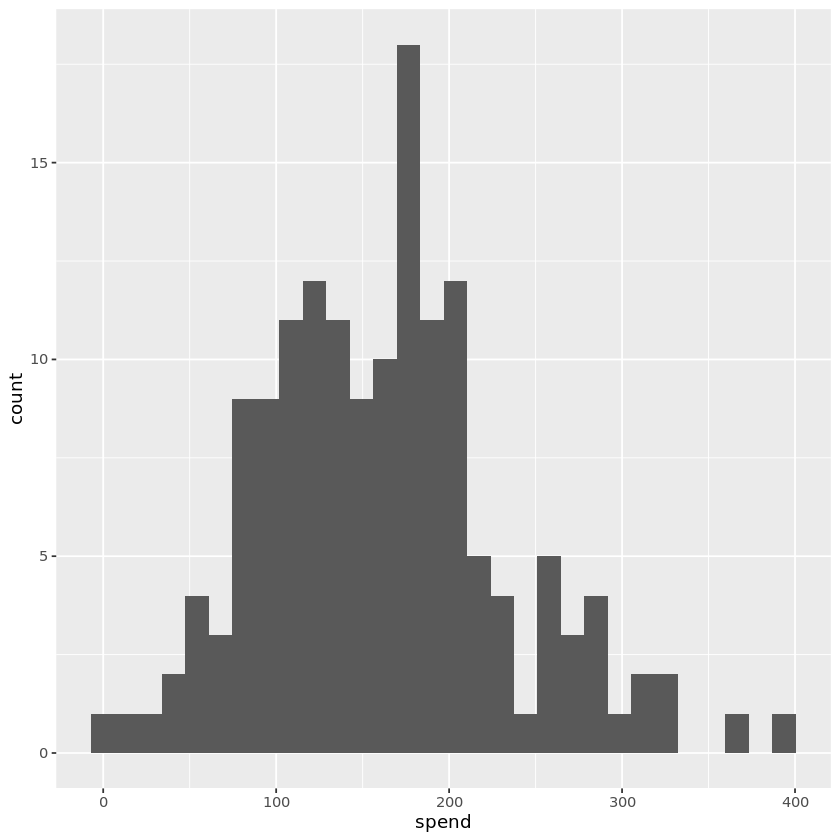

In [9]:
## plot the distribution of spend
ggplot(combined, aes(x = spend)) +
  geom_histogram()

***

<br>

### Frequentist Approach

<br>

In [10]:
# subset conversion and spend to perform F and t tests
# Creating objects to perform tests!

spend_designer <- combined %>%
  filter(conversion == 1,
         group == "Designer") %>%
  select(spend)

spend_house <- combined %>%
  filter(conversion == 1,
         group == "In-House") %>%
  select(spend)

conv_designer <- combined %>%
  filter(group == "Designer")

conv_house <- combined %>%
  filter(group == "In-House")

In [69]:
## F test to compare variance between groups
var.test(spend_designer$spend, spend_house$spend,  alternative = c("two.sided"), conf.level = 0.95)


	F test to compare two variances

data:  spend_designer$spend and spend_house$spend
F = 1.5149, num df = 84, denom df = 67, p-value = 0.07869
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.9529633 2.3795366
sample estimates:
ratio of variances 
          1.514859 


Not significant at the 95 confidence level

<br>

In [70]:
var.test(conv_designer$conversion, conv_house$conversion,  alternative = c("two.sided"), conf.level = 0.95)


	F test to compare two variances

data:  conv_designer$conversion and conv_house$conversion
F = 1.239, num df = 1998, denom df = 1998, p-value = 1.715e-06
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.134940 1.352591
sample estimates:
ratio of variances 
          1.238995 


Significant at the 99% confidence level

<br>

In [12]:
## t-test conversion
t.test(conversion~group, data = combined, var.equal = FALSE)


	Welch Two Sample t-test

data:  conversion by group
t = 1.4014, df = 3951, p-value = 0.1612
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.003392894  0.020401399
sample estimates:
mean in group Designer mean in group In-House 
            0.04252126             0.03401701 


Not significant at the 95% confidence level

<br>

In [13]:
## t-test spend
spend <- combined %>%
  filter(conversion == 1)

In [14]:
t.test(spend~group, data = spend, var.equal = TRUE)


	Two Sample t-test

data:  spend by group
t = 1.8667, df = 151, p-value = 0.06388
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.235392 43.503745
sample estimates:
mean in group Designer mean in group In-House 
              170.7409               149.6068 


Significant at the 90% confidence level

<br>

In [15]:
### Frequentist regression

conv_fit_freq <- glm(conversion ~ group,
                     data = combined,
                     family = binomial())

summary(conv_fit_freq)


Call:
glm(formula = conversion ~ group, family = binomial(), data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.2948  -0.2948  -0.2631  -0.2631   2.6003  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -3.1143     0.1108 -28.095   <2e-16 ***
groupIn-House  -0.2320     0.1659  -1.399    0.162    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1298.6  on 3997  degrees of freedom
Residual deviance: 1296.6  on 3996  degrees of freedom
AIC: 1300.6

Number of Fisher Scoring iterations: 6


The Treatment is not significant in altering conversion

<br>

In [16]:
### Frequentist regression

spend_fit_freq <- glm(spend ~ group,
                      data = combined)

summary(spend_fit_freq)


Call:
glm(formula = spend ~ group, data = combined)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-165.521   -48.211     1.699    35.349   228.059  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    170.741      7.548  22.621   <2e-16 ***
groupIn-House  -21.134     11.322  -1.867   0.0639 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 4842.461)

    Null deviance: 748085  on 152  degrees of freedom
Residual deviance: 731212  on 151  degrees of freedom
  (3845 observations deleted due to missingness)
AIC: 1736.4

Number of Fisher Scoring iterations: 2


The Treatment is significant at the 90% confidence level

<BR>

 If there was no difference in our variants, our data would only occur 8% of the time (4% if we’re using a less-conservative one-tailed test), thus, we’re pretty confident that there is a difference between our two variants. And, with $1.90 on the table for each email sent on an audience of ~1 million customers, we could be looking at an extra $1.9 million in revenues! We don’t want to miss an opportunity like that without really analyzing our results.

<br>

***

<br>

### Bayesian Approach

<br>

In [17]:
### Bayesian Conversion Regression

conv_fit_bayes = stan_glm(cbind(conversions, customers - conversions) ~ group,
                          family = binomial(link = logit), chains = 4, 
                          iter = 4000, warmup = 2000,
                          data = combined_summary)


SAMPLING FOR MODEL 'binomial' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4.8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 4000 [  0%]  (Warmup)
Chain 1: Iteration:  400 / 4000 [ 10%]  (Warmup)
Chain 1: Iteration:  800 / 4000 [ 20%]  (Warmup)
Chain 1: Iteration: 1200 / 4000 [ 30%]  (Warmup)
Chain 1: Iteration: 1600 / 4000 [ 40%]  (Warmup)
Chain 1: Iteration: 2000 / 4000 [ 50%]  (Warmup)
Chain 1: Iteration: 2001 / 4000 [ 50%]  (Sampling)
Chain 1: Iteration: 2400 / 4000 [ 60%]  (Sampling)
Chain 1: Iteration: 2800 / 4000 [ 70%]  (Sampling)
Chain 1: Iteration: 3200 / 4000 [ 80%]  (Sampling)
Chain 1: Iteration: 3600 / 4000 [ 90%]  (Sampling)
Chain 1: Iteration: 4000 / 4000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.052097 seconds (Warm-up)
Chain 1:                0.059456 seconds (Sampling)
Chain 1:                

In [18]:
summary(conv_fit_bayes, digits = 3)


Model Info:
 function:     stan_glm
 family:       binomial [logit]
 formula:      cbind(conversions, customers - conversions) ~ group
 algorithm:    sampling
 sample:       8000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 2
 predictors:   2

Estimates:
                mean   sd     10%    50%    90% 
(Intercept)   -3.120  0.113 -3.267 -3.118 -2.977
groupIn-House -0.226  0.168 -0.443 -0.227 -0.007

Fit Diagnostics:
           mean   sd     10%    50%    90% 
mean_PPD 76.787  8.578 66.000 76.500 88.000

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
              mcse  Rhat  n_eff
(Intercept)   0.002 1.000 5464 
groupIn-House 0.002 1.001 5383 
mean_PPD      0.109 1.000 6146 
log-posterior 0.019 1.001 2979 

For each parameter, mcse is Monte Carlo standard error, n_eff is a crude measure of effective sample size, and Rhat is the potential scale r

In [19]:
prior_summary(conv_fit_bayes)

Priors for model 'conv_fit_bayes' 
------
Intercept (after predictors centered)
 ~ normal(location = 0, scale = 2.5)

Coefficients
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 3.5)
------
See help('prior_summary.stanreg') for more details

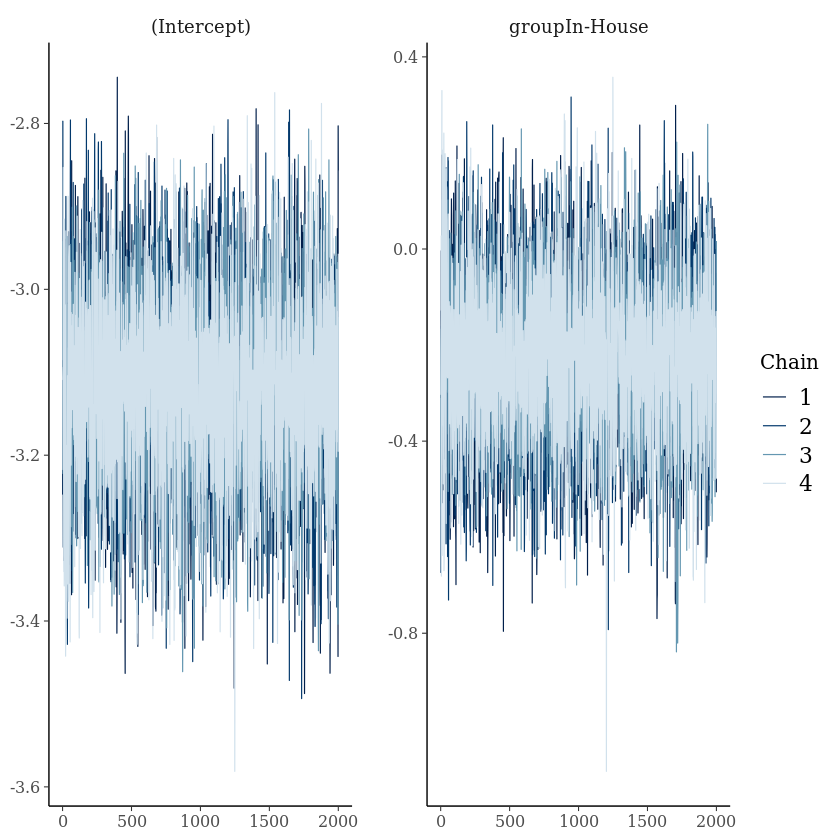

In [20]:
plot(conv_fit_bayes, "trace")

In [21]:
ci85 <- posterior_interval(conv_fit_bayes, prob = 0.85, pars = "groupIn-House")
round(ci85, 2)

,7.5%,92.5%
groupIn-House,-0.47,0.02


In [22]:
View(as.data.frame(conv_fit_bayes))

(Intercept),groupIn-House
<dbl>,<dbl>
-3.247530,-0.128058741
-3.085993,-0.205433891
-3.112743,-0.309335239
-3.194256,-0.003910874
-3.207749,-0.190881243
-3.108659,-0.129991113
-3.183824,-0.034694887
-3.326918,0.195405207
-3.273908,0.042491317


In [23]:
conv_fit_samples <- as.data.frame(conv_fit_bayes) %>%
  set_names(c("intercept_conv",
              "In_House_Flag_conv"))

In [24]:
View(conv_fit_samples)

intercept_conv,In_House_Flag_conv
<dbl>,<dbl>
-3.247530,-0.128058741
-3.085993,-0.205433891
-3.112743,-0.309335239
-3.194256,-0.003910874
-3.207749,-0.190881243
-3.108659,-0.129991113
-3.183824,-0.034694887
-3.326918,0.195405207
-3.273908,0.042491317


In [25]:
## get likelihood of condition from the posterior properties
conv_fit_samples %>%
  summarise(`Designer > In-House` = mean(0 > In_House_Flag_conv)) %>%
  t %>%
  as.data.frame %>%
  rownames_to_column() %>%
  mutate_if(is.numeric, scales::percent) %>%
  set_names(c("Condition", "Probability of Condition"))

Condition,Probability of Condition
<chr>,<chr>
Designer > In-House,91%


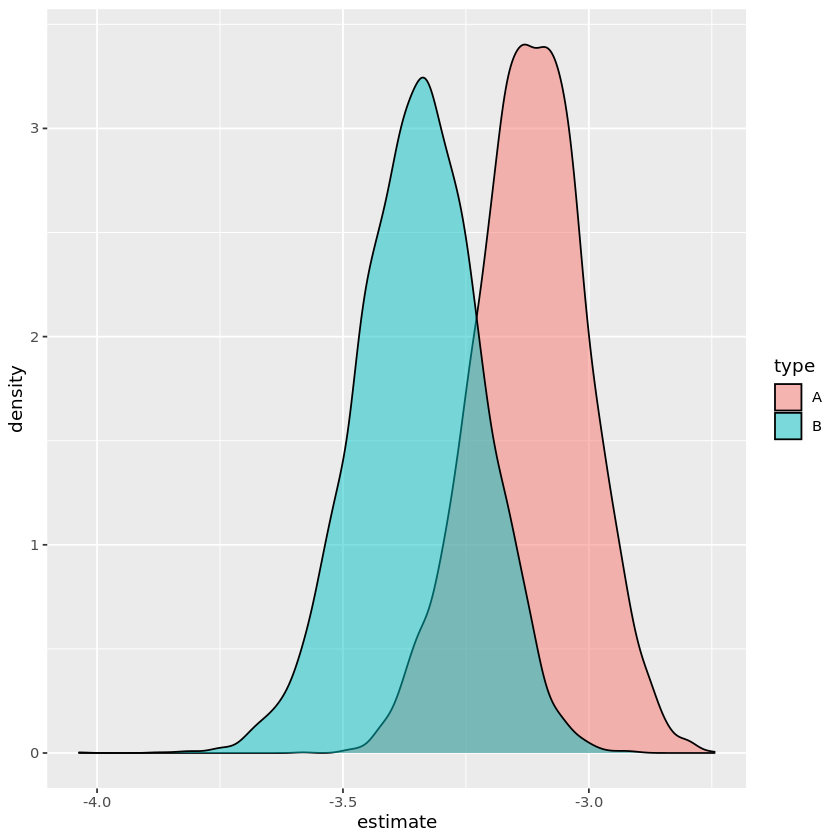

In [26]:
## Plot the posterior distributions of each group
conv_fit_samples %>%
  mutate(A = intercept_conv,
         B = intercept_conv + In_House_Flag_conv) %>%
  tidyr::gather(type, estimate, -In_House_Flag_conv, -intercept_conv) %>%
  ggplot(aes(estimate, fill = type)) +
  geom_density(alpha = 0.5)

In [27]:
##### Bayesian Spend Regression
spend_fit_bayes = stan_glm(spend ~ group,
                           chains = 4,
                           iter = 6000, warmup = 4000,
                           data = combined)


SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000113 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 6000 [  0%]  (Warmup)
Chain 1: Iteration:  600 / 6000 [ 10%]  (Warmup)
Chain 1: Iteration: 1200 / 6000 [ 20%]  (Warmup)
Chain 1: Iteration: 1800 / 6000 [ 30%]  (Warmup)
Chain 1: Iteration: 2400 / 6000 [ 40%]  (Warmup)
Chain 1: Iteration: 3000 / 6000 [ 50%]  (Warmup)
Chain 1: Iteration: 3600 / 6000 [ 60%]  (Warmup)
Chain 1: Iteration: 4001 / 6000 [ 66%]  (Sampling)
Chain 1: Iteration: 4600 / 6000 [ 76%]  (Sampling)
Chain 1: Iteration: 5200 / 6000 [ 86%]  (Sampling)
Chain 1: Iteration: 5800 / 6000 [ 96%]  (Sampling)
Chain 1: Iteration: 6000 / 6000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.200618 seconds (Warm-up)
Chain 1:                0.101221 seconds (Sampling)
Chain 1:               

In [28]:
summary(spend_fit_bayes, digits = 3)


Model Info:
 function:     stan_glm
 family:       gaussian [identity]
 formula:      spend ~ group
 algorithm:    sampling
 sample:       8000 (posterior sample size)
 priors:       see help('prior_summary')
 observations: 153
 predictors:   2

Estimates:
                mean    sd      10%     50%     90%  
(Intercept)   170.791   7.661 161.122 170.745 180.474
groupIn-House -21.071  11.407 -35.330 -21.141  -6.553
sigma          69.899   3.954  64.976  69.747  75.028

Fit Diagnostics:
           mean    sd      10%     50%     90%  
mean_PPD 161.466   8.075 150.992 161.459 171.661

The mean_ppd is the sample average posterior predictive distribution of the outcome variable (for details see help('summary.stanreg')).

MCMC diagnostics
              mcse  Rhat  n_eff
(Intercept)   0.090 1.000 7321 
groupIn-House 0.130 1.000 7744 
sigma         0.045 1.000 7890 
mean_PPD      0.093 1.000 7567 
log-posterior 0.020 1.000 3711 

For each parameter, mcse is Monte Carlo standard error, n_eff 

In [29]:
prior_summary(spend_fit_bayes)

Priors for model 'spend_fit_bayes' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 161, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 161, scale = 175)

Coefficients
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 352)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.014)
------
See help('prior_summary.stanreg') for more details

In [30]:
ci85 <- posterior_interval(spend_fit_bayes, prob = 0.85, pars = "groupIn-House")
round(ci85, 2)

,7.5%,92.5%
groupIn-House,-37.16,-4.64


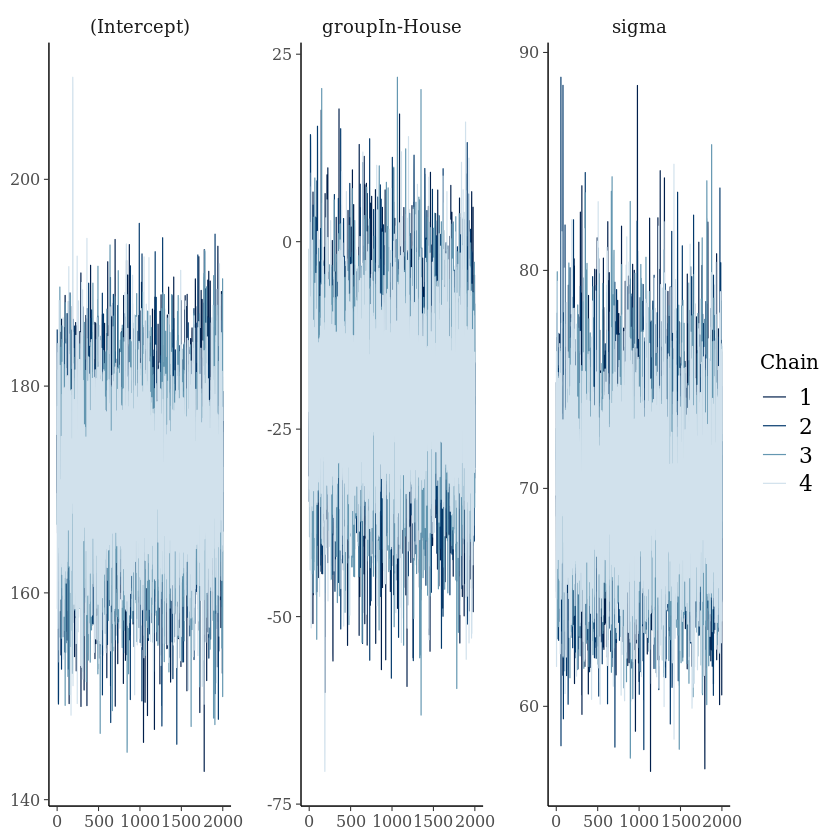

In [31]:
plot(spend_fit_bayes, "trace")

In [32]:
spend_fit_samples <- as.data.frame(spend_fit_bayes) %>%
  set_names(c("intercept_spend",
              "In_House_Flag_spend",
              "Sigma"))

In [33]:
#View(spend_fit_samples)

spend_fit_samples %>%
  summarise(`Group A > Group B` = mean(0 > In_House_Flag_spend)) %>%
  t %>%
  as.data.frame %>%
  rownames_to_column() %>%
  mutate_if(is.numeric, scales::percent) %>%
  set_names(c("Condition", "Probability of Condition"))

Condition,Probability of Condition
<chr>,<chr>
Group A > Group B,97%


In [34]:
spend_fit_samples %>%
  summarise(`Group A - Group B` = mean((intercept_spend) - (intercept_spend + In_House_Flag_spend)),
            `Group B - Group A` = mean((intercept_spend + In_House_Flag_spend) - intercept_spend))

Group A - Group B,Group B - Group A
<dbl>,<dbl>
21.07061,-21.07061


In [35]:
##### Combined overall results

overall_results <- conv_fit_samples %>%
  bind_cols(spend_fit_samples)

In [36]:
overall_results %>%
  summarise(`Group A > Group B` = mean((plogis(intercept_conv)*(intercept_spend)) > 
                                         (plogis(intercept_conv + In_House_Flag_conv) * (intercept_spend + In_House_Flag_spend)))) %>%
  mutate_if(is.numeric, scales::percent)

Group A > Group B
<chr>
98%


In [37]:
overall_results %>%
  summarise(`Group A - Group B` = mean((plogis(intercept_conv) * (intercept_spend)) - 
                                         (plogis(intercept_conv + In_House_Flag_conv) * (intercept_spend + In_House_Flag_spend)))) %>%
  mutate_if(is.numeric, scales::dollar)

Group A - Group B
<chr>
$2.14


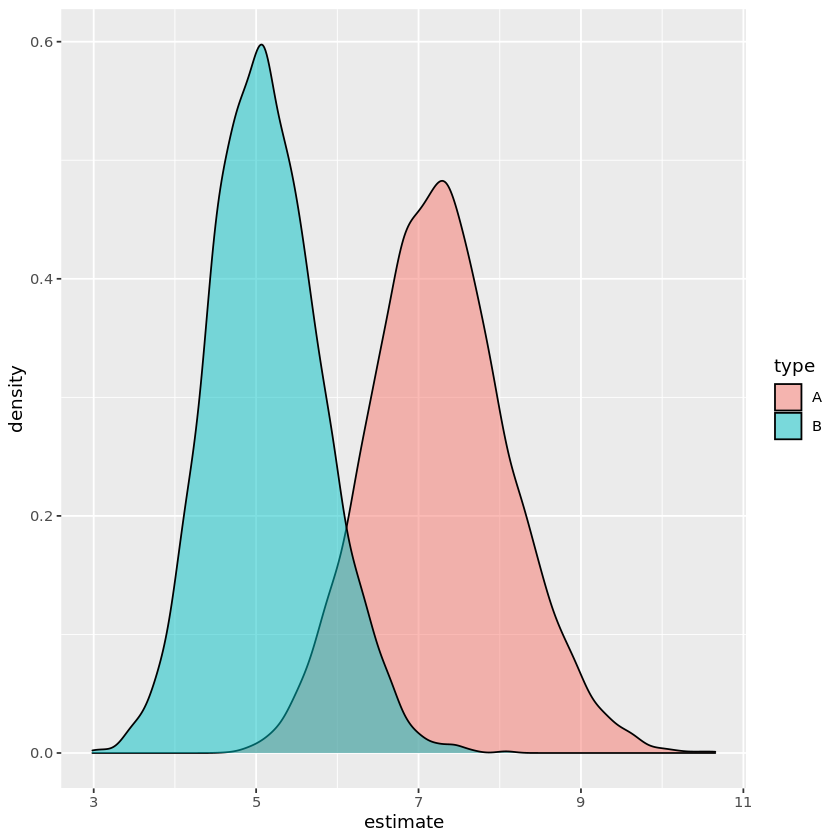

In [38]:
overall_results %>%
  mutate(A = (plogis(intercept_conv) * (intercept_spend)),
         B = (plogis(intercept_conv + In_House_Flag_conv) * (intercept_spend + In_House_Flag_spend))) %>%
  tidyr::gather(type, estimate, -In_House_Flag_conv, -intercept_conv, -intercept_spend, -In_House_Flag_spend, -Sigma) %>%
  ggplot(aes(estimate, fill = type)) +
  geom_density(alpha = 0.5)

<br>

***

***

***

<br>

# End Script